# Generative Adversarial Networks

Ian Goodfellow was the one who presented the original paper on Generative Adversarial Networks. 

The basic idea is to have two models, one generative, one discriminative, where the discriminator is attempting to determine if the generator is giving 
reasonable outputs or not.

### Deep Convolutional GAN (DCGAN)




In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses, utils, metrics, optimizers

from utils import display, sample_batch

IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

### Grab the Lego data.

Found 40000 files belonging to 1 classes.


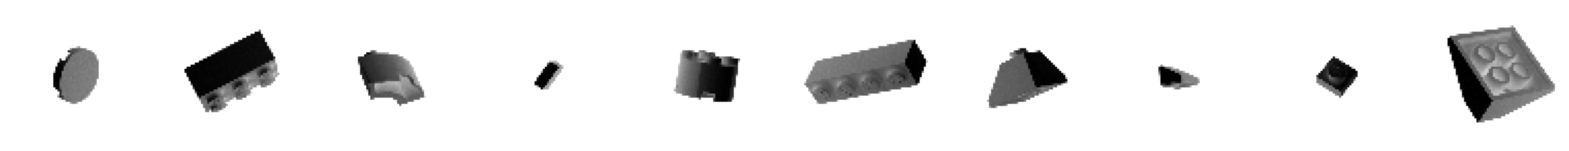

In [3]:
training_data = utils.image_dataset_from_directory(
    "archive/dataset", 
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation='bilinear',
)

def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img,"float32") - 127.5) / 127.5
    return img 

train = training_data.map( lambda x: preprocess(x))
train_sample = sample_batch(train)
display(train_sample)


In [4]:
discriminator_input = layers.Input(shape=(64, 64, 1)) 
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias = False)(
    discriminator_input
) 
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias = False,
    activation = 'sigmoid'
)(x)
discriminator_output = layers.Flatten()(x) 

discriminator = models.Model(discriminator_input, discriminator_output) 

Note, that in some of the `Conv2D` layers the stride is set to 2, to reduce
the spatial shape of the tensor as it passes through the network (64 to 32, to 
16 to 8, down to 4, to 2, and finally 1), while increasing the number of channels.

In [5]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

## The Generator

Now, time to build the generator.

In [7]:
generator_input = layers.Input(shape=(100,)) 
x = layers.Reshape((1, 1, 100))(generator_input) 
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias = False
)(x) 
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    1,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias = False,
    activation = 'tanh'
)(x) 
generator = models.Model(generator_input, generator_output) 
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 4, 4, 512)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_7 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 8, 8, 256)         2097

## Training the DCGAN

As we have seen, the architectures of the generator and discriminator in a DCGAN are very simple and not so different from the VAE models that we looked at earlier. The key to understanding GANs lies in understanding the training process for the generator and discriminator.

We can train the discriminator by creating a training set where some of the images are real observations from the training set and some are fake outputs from the generator. We then treat this as a supervised learning problem, where the labels are 1 for the real images and 0 for the fake images, with binary cross-entropy as the loss function.

How do we train the generator? We need to find a way of scoring each generated image so that it can optimize toward high-scoring images. Luckily, we have a discriminator that does exactly that! We can generate a batch of images and pass these through the discriminator to get a score for each image. The loss function for the generator is then simply the binary cross-entropy between these probabilities and a vector of ones, because we want to train the generator to produce images that the discriminator thinks are real.

Crucially, we must alternate the training of these two networks, making sure that we only update the weights of one network at a time. For example, during the generator training process, only the generator’s weights are updated. If we allowed the discriminator’s weights to change as well, the discriminator would just adjust so that it is more likely to predict the generated images to be real, which is not the desired outcome. We want generated images to be predicted close to 1 (real) because the generator is strong, not because the discriminator is weak.

**Keras** provides an ability to create a custom `train_step` function to implement this logic.



In [8]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [9]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [ ]:
if LOAD_MODEL:
    dcgan.load_weights("checkpoint.ckpt")


## Train the GAN

Train the GAN

In [10]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [11]:
dcgan.fit(train, epochs=300)

Epoch 1/300
313/313 [==============================] - 306s 973ms/step - d_loss: 0.1917 - d_real_acc: 0.8569 - d_fake_acc: 0.8743 - d_acc: 0.8656 - g_loss: 4.7291 - g_acc: 0.1257
Epoch 2/300
313/313 [==============================] - 308s 982ms/step - d_loss: -0.0102 - d_real_acc: 0.9028 - d_fake_acc: 0.9187 - d_acc: 0.9107 - g_loss: 5.3931 - g_acc: 0.0813
Epoch 3/300
313/313 [==============================] - 304s 969ms/step - d_loss: -0.0798 - d_real_acc: 0.9178 - d_fake_acc: 0.9249 - d_acc: 0.9213 - g_loss: 7.1770 - g_acc: 0.0751
Epoch 4/300
313/313 [==============================] - 299s 955ms/step - d_loss: 0.0997 - d_real_acc: 0.8820 - d_fake_acc: 0.8835 - d_acc: 0.8827 - g_loss: 5.4638 - g_acc: 0.1165
Epoch 5/300
313/313 [==============================] - 291s 928ms/step - d_loss: 0.1549 - d_real_acc: 0.8739 - d_fake_acc: 0.8776 - d_acc: 0.8758 - g_loss: 4.4395 - g_acc: 0.1224
Epoch 6/300
313/313 [==============================] - 298s 951ms/step - d_loss: 0.1369 - d_real_acc: 0

The discriminator and generator are constantly fighting for dominance, which can make the DCGAN training process unstable. Ideally, the training process will find an equilibrium that allows the generator to learn meaningful information from the discriminator and the quality of the images will start to improve. After enough epochs, the discriminator tends to end up dominating, as shown in Figure 4-6, but this may not be a problem as the generator may have already learned to produce sufficiently high-quality images by this point.

In [12]:
# Save the final models
generator.save("generator")
discriminator.save("discriminator")

INFO:tensorflow:Assets written to: generator/assets


INFO:tensorflow:Assets written to: generator/assets


INFO:tensorflow:Assets written to: discriminator/assets


INFO:tensorflow:Assets written to: discriminator/assets


### Generate some new images

1/1 [==============================] - 0s 151ms/step


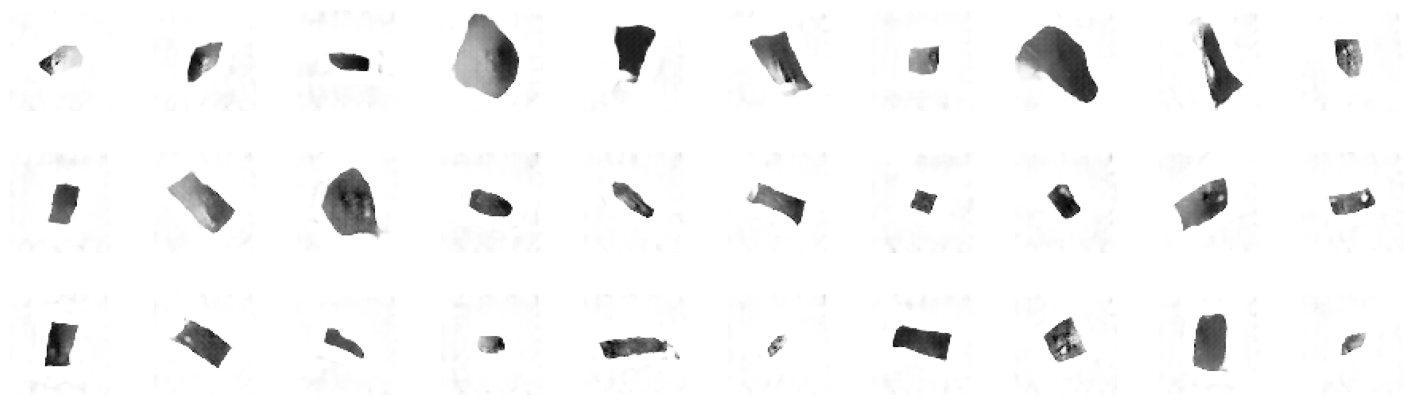

In [13]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

# Decode the sampled points
reconstructions = generator.predict(z_sample)

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [14]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 [==============================] - 0s 51ms/step


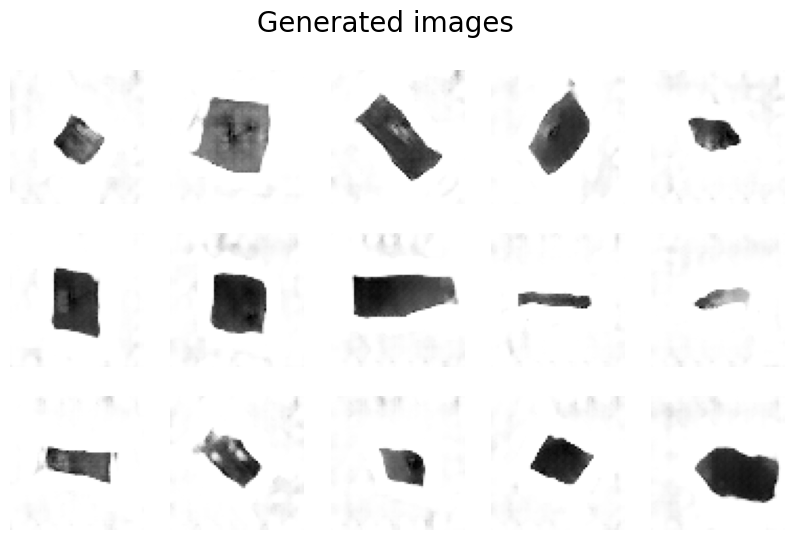

In [15]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

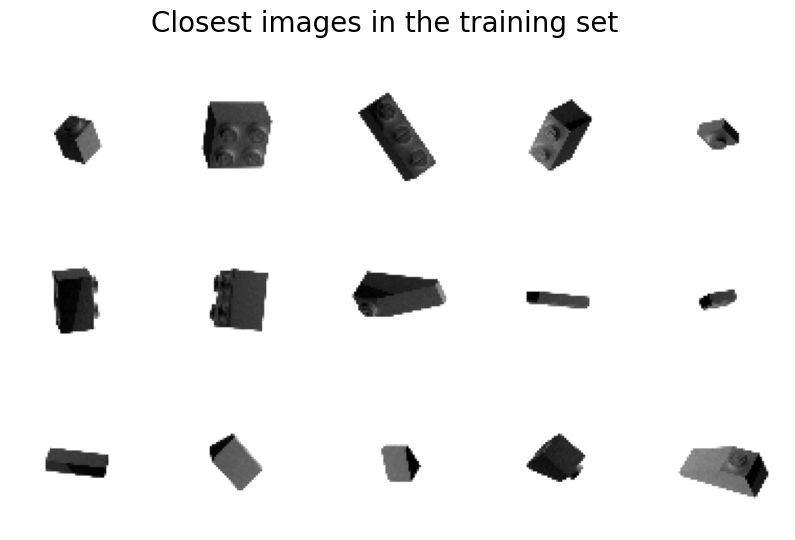

In [16]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

### GAN Training: Tips and Tricks

While GANs are a major breakthrough for generative modeling, they are also notoriously difficult to train. Let's explore some of the most common problems and challenges encountered when training GANs in this section, alongside potential solutions. In the next section, we will look at some more fundamental adjustments to the GAN framework that we can make to remedy many of these problems.

### Discriminator overpowers the generator

If the discriminator becomes too strong, the signal from the loss function becomes too weak to drive any meaningful improvements in the generator. In the worst-case scenario, the discriminator perfectly learns to separate real images from fake images and the gradients vanish completely, leading to no training whatsoever.

If you find your discriminator loss function collapsing, you need to find ways to weaken the discriminator. Try the following suggestions:

* Increase the rate parameter of the Dropout layers in the discriminator to dampen the amount of information that flows through the network.
* Reduce the learning rate of the discriminator.
* Reduce the number of convolutional filters in the discriminator.
* Add noise to the labels when training the discriminator.
* Flip the labels of some images at random when training the discriminator.

### Generator overpowers the discriminator

If the discriminator is not powerful enough, the generator will find ways to easily trick the discriminator with a small sample of nearly identical images. This is known as mode collapse.

For example, suppose we were to train the generator over several batches without updating the discriminator in between. The generator would be inclined to find a single observation (also known as a mode) that always fools the discriminator and would start to map every point in the latent input space to this image. Moreover, the gradients of the loss function would collapse to near 0, so it wouldn’t be able to recover from this state.

Even if we then tried to retrain the discriminator to stop it being fooled by this one point, the generator would simply find another mode that fools the discriminator, since it has already become numb to its input and therefore has no incentive to diversify its output.